In [1]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from msrest.authentication import CognitiveServicesCredentials
from array import array
import os
from PIL import Image
import sys
import time

from dotenv import load_dotenv
import os

# Încarcă variabilele de mediu din fișierul .env
load_dotenv()
'''
Authenticate
Authenticates your credentials and creates a client.
'''
subscription_key = os.environ["VISION_KEY"]
endpoint = os.environ["VISION_ENDPOINT"]
computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))
'''
END - Authenticate
'''

def returnCoordonates(imagePath):
    """ 
    Returns a list of coordonates that frame a line of text
    """
    img = open(imagePath, "rb")
    read_response = computervision_client.read_in_stream(
        image=img,
        mode="Printed",
        raw=True
    )
    operation_id = read_response.headers['Operation-Location'].split('/')[-1]
    while True:
        read_result = computervision_client.get_read_result(operation_id)
        if read_result.status not in ['notStarted', 'running']:
            break
        time.sleep(1)

    coordonates = []
    if read_result.status == OperationStatusCodes.succeeded:
        for text_result in read_result.analyze_result.read_results:
            for line in text_result.lines:
                for word in line.words:
                    x_top_left = word.bounding_box[0]
                    y_top_left = word.bounding_box[1]

                    x_bottom_right = word.bounding_box[4]
                    y_bottom_right = word.bounding_box[5]

                    coordonates.append(((x_top_left, y_top_left), (x_bottom_right, y_bottom_right)))

    return coordonates


In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as ptc
from PIL import Image

def frameTextInImage(imagePath):
    """  
    Frame a text from an image with the given image path
    """
    image = Image.open(imagePath)

    fig, ax = plt.subplots();
    ax.imshow(image)

    coordonates = returnCoordonates(imagePath)
    for top_left, bottom_right in coordonates:
        rect = ptc.Rectangle(top_left, width=(bottom_right[0]-top_left[0]), height=(bottom_right[1] - top_left[1]), linewidth=1, edgecolor='b', facecolor='none')
        ax.add_patch(rect)
    
    plt.show()

def rectangleArea(top_left, bottom_right):
    """ 
    Returns the area of a rectangle with the given top left and bottom right point coordonates
    """
    height = bottom_right[1] - top_left[1]
    width = bottom_right[0]-top_left[0]
    area = height * width
    return area

def frameTextInImage2(imagePath):
    """  
    Frame a text from an image with the given image path
    """
    image = Image.open(imagePath)

    fig, ax = plt.subplots();
    ax.imshow(image)

    coordonates = returnCoordonates(imagePath)
    for top_left, bottom_right in coordonates:
        rect = ptc.Rectangle((top_left[0], top_left[1] - 13), width=(bottom_right[0]-top_left[0]), height=(bottom_right[1] + 22 - top_left[1]), linewidth=1, edgecolor='b', facecolor='none')
        print((top_left[0], top_left[1] - 13), (bottom_right[0], bottom_right[1] + 22))
        print()
        ax.add_patch(rect)


def intersectionArea(top_left, bottom_right, expected_top_left, expected_bottom_right):
    """ 
    returns the intersection area of the two areas defined by the given point coordonates
    """
    intersection_top_left = (max(top_left[0], expected_top_left[0]), min(top_left[1], expected_top_left[1]))
    intersection_bottom_right = (max(bottom_right[0], expected_bottom_right[0]), min(bottom_right[1], expected_bottom_right[1]))

    intersection_area = rectangleArea(intersection_top_left, intersection_bottom_right)
    return intersection_area

def expectedArea(expected_top_left, expected_bottom_right):
    """ 
    returns the expected area that defines a text given by these coordonates
    """
    expected_area = rectangleArea(expected_top_left, expected_bottom_right)
    return expected_area

def rateError(intersection_area, expected_area):
    return intersection_area / expected_area

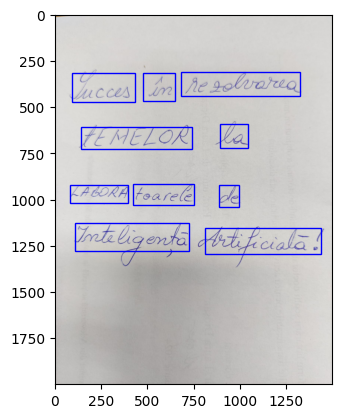

Rate error =  1.2459016393442623


In [5]:
def main():
    #PROBLEMA 2
    #stanga sus, dreapta sus, dreapta jos, stanga jos
    # coorodnates = returnCoordonates("test1.png")
    # print(coorodnates)
    coordonates = returnCoordonates("test1.png")
    frameTextInImage("test1.png") 
    top_left = coordonates[0][0]
    bottom_right = coordonates[1][0]

    expected_top_left = (174.0, 40.0)
    expected_bottom_right = (418.0, 115.0)

    intersection_area = intersectionArea(top_left, bottom_right, expected_top_left, expected_bottom_right)
    expected_area = expectedArea(expected_top_left, expected_bottom_right)

    rate_error = rateError(intersection_area, expected_area)
    print("Rate error = ", rate_error)


main()